# Clasificación multi-etiqueta

![mlr](../../images/mlr.png)


![telecom](../../images/telecom.jpeg)

In [1]:
import pandas as pd                                # panel data, for handling dataframes
pd.set_option('display.max_columns', None)         # show all columns of the dataframe

import numpy as np                                 # numerical python, linear algebra library

import pylab as plt                                # plotting library
import seaborn as sns                              # plotting library
sns.set(style='white')                             # seaborn style


from sklearn.linear_model import LogisticRegression, SGDClassifier # logistic regression model & Gradient Descent                  
from sklearn.preprocessing import MinMaxScaler               # standarized
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, confusion_matrix

from sklearn.model_selection import train_test_split as tts    # split data into train and test sets

## Cargar Datos

In [2]:
df=pd.read_csv('../../../data/churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthLevel,TotalLevel,TenureLevel,ChurnBinary
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Low,Very Low,New,0.0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Low,Moderate,Loyal,0.0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Low,Very Low,New,1.0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Low,Moderate,Loyal,0.0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Moderate,Very Low,New,1.0


In [3]:
df.Contract.value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64

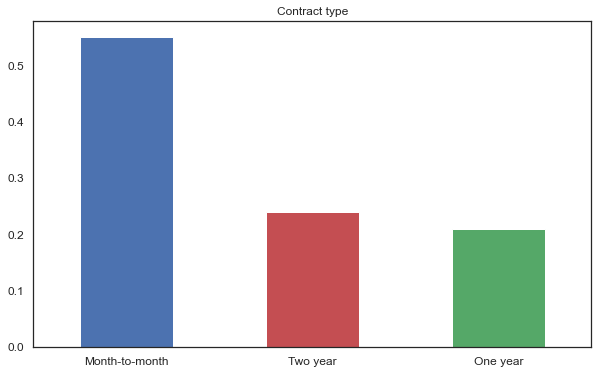

In [4]:
(df.Contract.value_counts()/len(df)).plot.bar(color=['b', 'r', 'g'],    
                                           figsize=(10, 6),
                                           title='Contract type',
                                           rot=0,
                                           fontsize=12);

## Transformacion

In [5]:
data_num=pd.DataFrame(MinMaxScaler().fit_transform(df._get_numeric_data()),  # standardize numeric columns
                      columns=df._get_numeric_data().columns)

data_obj=df.select_dtypes(include='object').drop('customerID',axis=1)  # get categoric columns


data=pd.concat([data_num, data_obj], axis=1)   # concatenate both dataframes

In [6]:
# En esta ocasión utilizaremos One Hot Encoder o dummies

dum = pd.get_dummies(data_obj.drop(['Contract'], axis=1))

In [7]:
data=pd.concat([data_num, dum, data_obj.Contract], axis=1) 

In [8]:
data.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,ChurnBinary,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes,MonthLevel_High,MonthLevel_Low,MonthLevel_Moderate,MonthLevel_Very High,MonthLevel_Very Low,TotalLevel_High,TotalLevel_Low,TotalLevel_Moderate,TotalLevel_Very High,TotalLevel_Very Low,TenureLevel_Loyal,TenureLevel_New,TenureLevel_Regular,TenureLevel_Very Loyal,Contract
0,0.0,0.000000,0.115423,0.001275,0.0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,Month-to-month
1,0.0,0.464789,0.385075,0.215867,0.0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,One year
2,0.0,0.014085,0.354229,0.010310,1.0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,Month-to-month
3,0.0,0.619718,0.239303,0.210241,0.0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,One year
4,0.0,0.014085,0.521891,0.015330,1.0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,Month-to-month


In [9]:
#Tendremos que codificar también nuestra variable dependiente
le = LabelEncoder()

data.Contract = le.fit_transform(data.Contract)

data.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,ChurnBinary,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes,MonthLevel_High,MonthLevel_Low,MonthLevel_Moderate,MonthLevel_Very High,MonthLevel_Very Low,TotalLevel_High,TotalLevel_Low,TotalLevel_Moderate,TotalLevel_Very High,TotalLevel_Very Low,TenureLevel_Loyal,TenureLevel_New,TenureLevel_Regular,TenureLevel_Very Loyal,Contract
0,0.0,0.000000,0.115423,0.001275,0.0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
1,0.0,0.464789,0.385075,0.215867,0.0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
2,0.0,0.014085,0.354229,0.010310,1.0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
3,0.0,0.619718,0.239303,0.210241,0.0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
4,0.0,0.014085,0.521891,0.015330,1.0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0


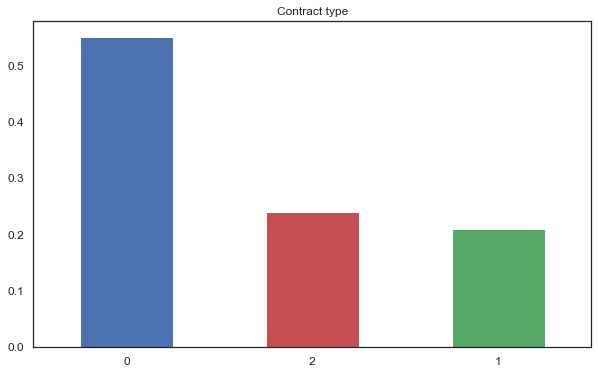

In [10]:
(data.Contract.value_counts()/len(data)).plot.bar(color=['b', 'r', 'g'],    
                                           figsize=(10, 6),
                                           title='Contract type',
                                           rot=0,
                                           fontsize=12);

## Modelado

In [11]:
X=data.drop(['Contract', 'ChurnBinary'], axis=1)   
# all data except target and ChurnBinary because it`s the same than Churn

y=data.Contract               
# target data

In [12]:
X_train, X_test, y_train, y_test=tts(X, y, random_state=42, stratify=y)

In [13]:
lr=LogisticRegression(max_iter=2000)
rf = RandomForestClassifier()
gd = SGDClassifier()
xgb = XGBClassifier()

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
gd.fit(X_train, y_train)
xgb.fit(X_train, y_train)

models = [lr, rf, gd, xgb]

Entrenando LogisticRegression .....

LogisticRegression Entrenado 

Realizando predicciones .... 

Evaluando LogisticRegression .....

Resultados LogisticRegression 

{'f1_train': 0.6830736284923744, 'f1_test': 0.6696823464407693}


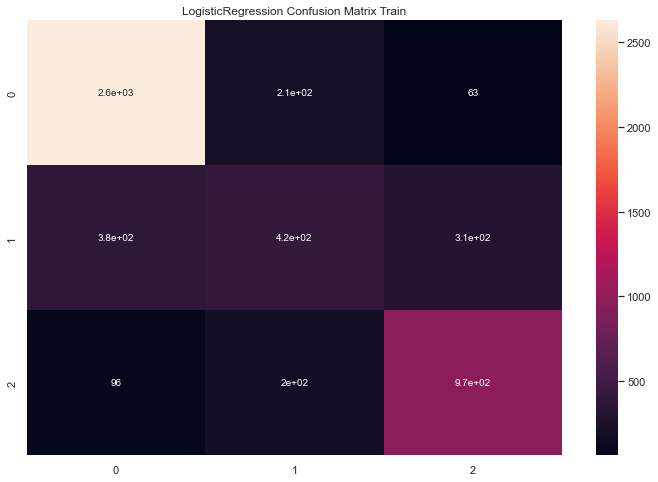

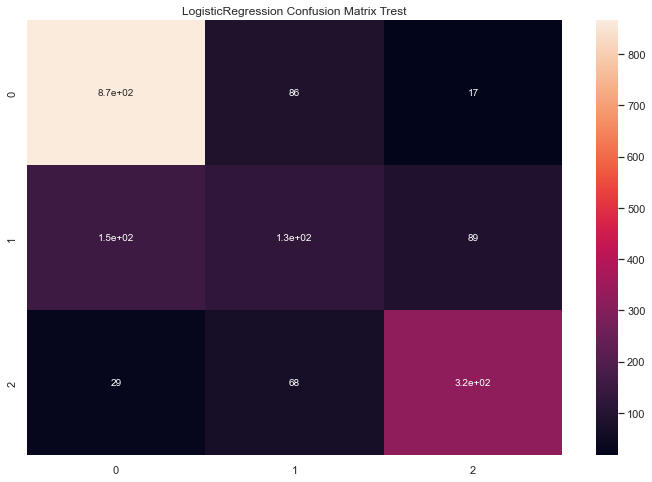

Entrenando RandomForestClassifier .....

RandomForestClassifier Entrenado 

Realizando predicciones .... 

Evaluando RandomForestClassifier .....

Resultados RandomForestClassifier 

{'f1_train': 0.9998107485432913, 'f1_test': 0.6668957750950185}


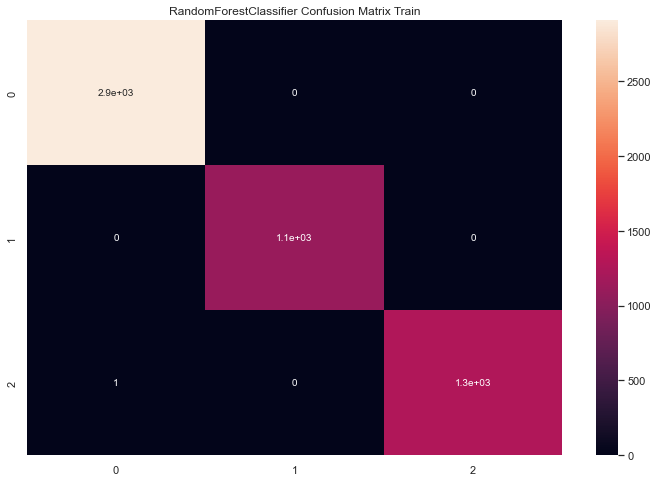

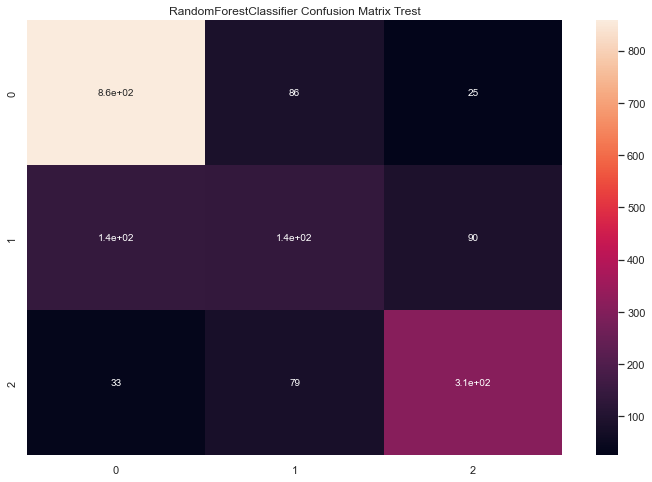

Entrenando SGDClassifier .....

SGDClassifier Entrenado 

Realizando predicciones .... 

Evaluando SGDClassifier .....

Resultados SGDClassifier 

{'f1_train': 0.5984803995539729, 'f1_test': 0.5953014804735066}


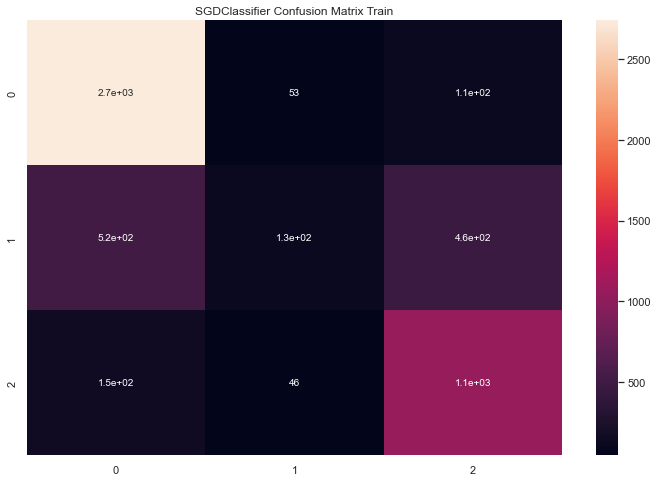

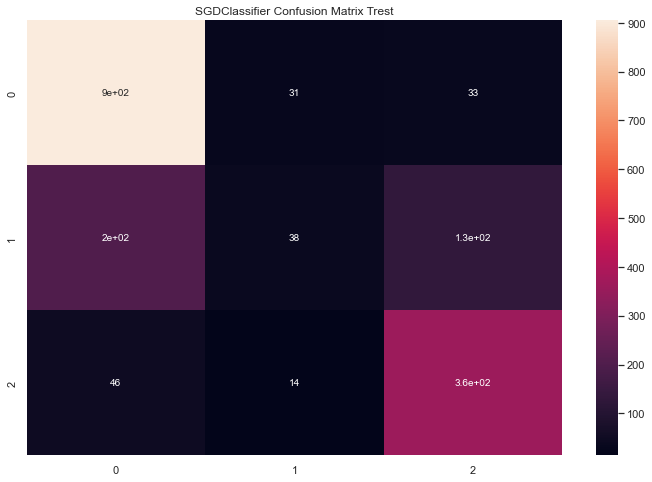

Entrenando XGBClassifier .....

XGBClassifier Entrenado 

Realizando predicciones .... 

Evaluando XGBClassifier .....

Resultados XGBClassifier 

{'f1_train': 0.9690247524532726, 'f1_test': 0.6638401754253206}


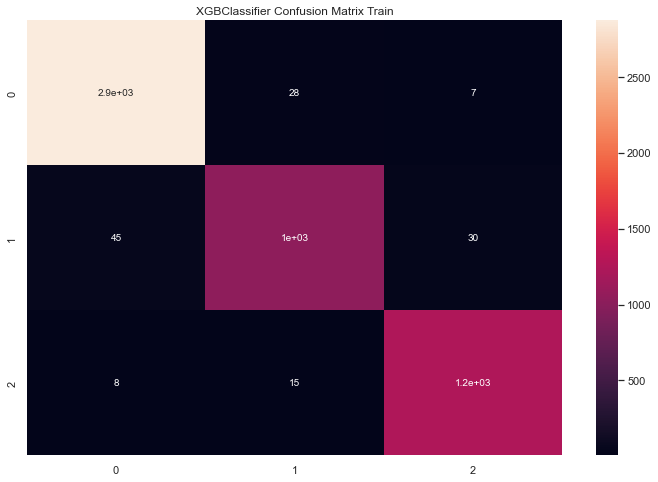

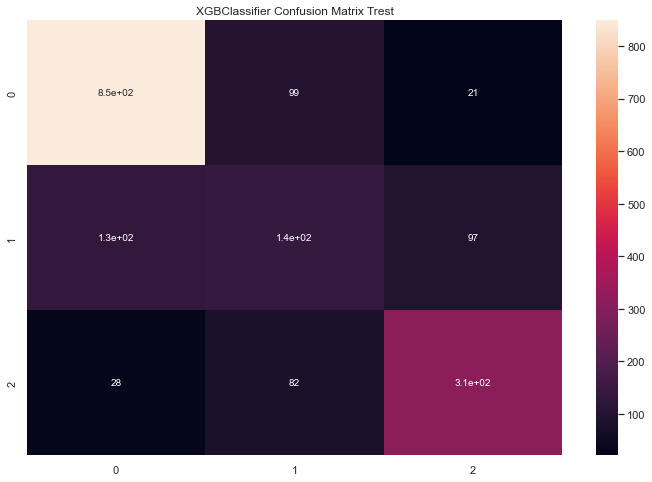

In [14]:
res = {}
for model in models:
    name = str(model).split('(')[0]
    print(f'Entrenando {name} .....\n')
    model.fit(X_train, y_train)
    print(f'{name} Entrenado \n')
    print(f'Realizando predicciones .... \n')
    pred = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f'Evaluando {name} .....\n')
    f1 = f1_score(y_train, pred, average='macro')
    f1_test = f1_score(y_test, pred_test,average='macro')
    cm = confusion_matrix(y_train, pred)
    cm_test = confusion_matrix(y_test, pred_test)
    
    res[name]={'f1_train': f1,
               'f1_test': f1_test}
    
    print(f'Resultados {name} \n')
    
    print(res[name])
    
    plt.figure(figsize=(12,8))
    sns.heatmap(cm, annot=True)
    plt.title(f'{name} Confusion Matrix Train')
    plt.show();
    plt.figure(figsize=(12,8))
    sns.heatmap(cm_test, annot=True)
    plt.title(f'{name} Confusion Matrix Trest')
    plt.show();
    

In [15]:
pd.DataFrame(res)

,LogisticRegression,RandomForestClassifier,SGDClassifier,XGBClassifier
f1_train,0.683074,0.999811,0.598480,0.969025
f1_test,0.669682,0.666896,0.595301,0.663840
